In [ ]:
""" Only use to run in Kaggle 

!pip uninstall -y scikit-learn xgboost

!pip install scikit-learn==1.4.2
!pip install xgboost==2.0.3
!pip install autogluon.tabular """

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: xgboost 2.0.3
Uninstalling xgboost-2.0.3:
  Successfully uninstalled xgboost-2.0.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 8.5 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tpot 0.12.1 requires xgboost>=1.1.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 9.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 14.0 M

In [117]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data analysis and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import LinearRegression
from autogluon.tabular import TabularPredictor

# Loadind dataset
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

target_df = train_df[['PassengerId', 'Transported']]

complete_df = pd.concat([train_df.drop('Transported', axis=1), test_df], axis=0, ignore_index=True)

## EDA - Spaceship Dataset

**Variables Qualitatives:**

* Nominal: Name, PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Transported
* Ordinal: -
 
**Variables Quantitatives:**
* Continuous: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
* Discrete: Age

In [118]:
complete_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [119]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.3+ MB


In [120]:
complete_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [121]:
print(f'Dataset Nulls:\n\n{complete_df.isnull().sum()}')

Dataset Nulls:

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
dtype: int64


### Feature Engineering

#### PassengerID

In [122]:
# New features based on PassengerID
complete_df['GroupId'] = complete_df['PassengerId'].str.split('_').str[0].astype(int)

group_sizes = complete_df['GroupId'].value_counts()
complete_df['GroupSize'] = complete_df['GroupId'].map(group_sizes)

complete_df['Solo'] = (complete_df['GroupSize'] == 1)

#### Cabin

In [123]:
# New features based on Cabin
complete_df['Cabin'] = complete_df['Cabin'].fillna('Unknown/Unknown/Unknown')

complete_df['CabinDeck'] = complete_df['Cabin'].str.split('/').str[0]
complete_df['CabinNum'] = pd.to_numeric(complete_df['Cabin'].str.split('/').str[1], errors="coerce").fillna(-1).astype(int)
complete_df['CabinSide'] = complete_df['Cabin'].str.split('/').str[2]

# Adding NaN again
complete_df['Cabin'] = complete_df['Cabin'].replace('Unknown/Unknown/Unknown', np.nan)
complete_df['CabinDeck'] = complete_df['CabinDeck'].replace('Unknown', np.nan)
complete_df['CabinSide'] = complete_df['CabinSide'].replace('Unknown', np.nan)
complete_df['CabinNum'] = complete_df['CabinNum'].replace(-1, np.nan)

#### Expenses

In [124]:
# New feature with the total spend on services, controlling the NaN
expenses_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

total_exp = complete_df[expenses_cols].fillna(0).sum(axis=1)
all_nan_mask = complete_df[expenses_cols].isna().all(axis=1)
complete_df['TotalExpense'] = total_exp.mask(all_nan_mask, np.nan)

#### Name

In [125]:
# New feature with just the surname of the people
complete_df['Surname'] = complete_df['Name'].str.split(' ').str[1]

In [126]:
complete_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,GroupId,GroupSize,Solo,CabinDeck,CabinNum,CabinSide,TotalExpense,Surname
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,1,1,True,B,0.0,P,0.0,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,2,1,True,F,0.0,S,736.0,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,3,2,False,A,0.0,S,10383.0,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,3,2,False,A,0.0,S,5176.0,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,4,1,True,F,1.0,S,1091.0,Santantines


### Missing Values

#### HomePlanet

In [127]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 288


In [128]:
# Revisamos si todas las personas del mismo grupo vienen del mismo planeta
group_planet_counts = complete_df.groupby("GroupId")["HomePlanet"].nunique().value_counts().reset_index()

group_planet_counts.columns = ['NumPlanetasDistintos', 'NumGrupos']
group_planet_counts

,NumPlanetasDistintos,NumGrupos
0,1,9124
1,0,156


In [129]:
# Rellenamos el planeta nan de las personas con grupo en el que se conozca algun home
group_planet = complete_df.groupby("GroupId")["HomePlanet"].apply(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan)

home_mask = complete_df["HomePlanet"].isna() & complete_df["GroupId"].isin(group_planet.dropna().index)
complete_df.loc[home_mask, "HomePlanet"] = complete_df.loc[home_mask, "GroupId"].map(group_planet)

In [130]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 157


In [131]:
# Revisamos si todas las personas del mismo apellido vienen del mismo planeta
surname_group_counts = complete_df.groupby("Surname")["HomePlanet"].nunique().value_counts().reset_index()

surname_group_counts.columns = ['NumHomesDistintos', 'NumSurnames']
surname_group_counts

,NumHomesDistintos,NumSurnames
0,1,2400
1,0,6


In [132]:
# Rellenamos el planeta nan de las personas con el mismo apellido
surname_planet = complete_df.groupby("Surname")["HomePlanet"].apply(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan)

surname_mask = complete_df["HomePlanet"].isna() & complete_df["Surname"].notna() & complete_df["Surname"].isin(surname_planet.dropna().index)
complete_df.loc[surname_mask, "HomePlanet"] = complete_df.loc[surname_mask, "Surname"].map(surname_planet)

In [133]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 13


In [134]:
# Revisamos si hay decks con solo un HomePlanet
deck_planet_list = complete_df.groupby("CabinDeck")["HomePlanet"].unique().reset_index()

deck_planet_list.columns = ['CabinDeck', 'Planetas']
deck_planet_list

,CabinDeck,Planetas
0,A,"[Europa, nan]"
1,B,[Europa]
2,C,"[Europa, nan]"
3,D,"[Mars, Europa, nan]"
4,E,"[Earth, Mars, Europa, nan]"
5,F,"[Earth, Mars, nan]"
6,G,"[Earth, nan]"
7,T,[Europa]


In [135]:
# Podemos ver que en el deck A, B, C y T solo hay Europa y en el G solo hay Earth, rellenamos los valores nan
deck_eur_mask = complete_df["HomePlanet"].isna() & complete_df["CabinDeck"].isin(['A', 'B', 'C', 'T'])
complete_df.loc[deck_eur_mask, "HomePlanet"] = 'Europa'

deck_ear_mask = complete_df["HomePlanet"].isna() & (complete_df["CabinDeck"]=='G')
complete_df.loc[deck_ear_mask, "HomePlanet"] = 'Earth'

In [136]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 10


In [137]:
# Revisamos los pasajeros con HomePlanet nan
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(complete_df[complete_df['HomePlanet'].isna()])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,GroupId,GroupSize,Solo,CabinDeck,CabinNum,CabinSide,TotalExpense,Surname
2274,2443_01,NaN,False,D/72/P,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,...,0.0,NaN,2443,1,True,D,72.0,P,1955.0,NaN
2631,2817_01,NaN,False,F/584/P,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,...,12.0,Sealfs Sutty,2817,1,True,F,584.0,P,1159.0,Sutty
3091,3331_01,NaN,False,F/631/S,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,...,50.0,NaN,3331,1,True,F,631.0,S,803.0,NaN
4548,4840_01,NaN,True,F/915/S,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,...,0.0,NaN,4840,1,True,F,915.0,S,0.0,NaN
5762,6108_01,NaN,False,F/1166/S,TRAPPIST-1e,13.0,False,206.0,28.0,0.0,...,629.0,NaN,6108,1,True,F,1166.0,S,864.0,NaN
8969,0616_01,NaN,False,E/40/S,TRAPPIST-1e,31.0,False,0.0,428.0,NaN,...,1025.0,Arkaban Spriney,616,1,True,E,40.0,S,2607.0,Spriney
10583,4052_01,NaN,False,D/136/P,TRAPPIST-1e,26.0,False,6.0,5903.0,0.0,...,72.0,Ankabih Coneveseng,4052,1,True,D,136.0,P,6221.0,Coneveseng
11913,7065_01,NaN,True,E/471/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,...,NaN,Zedares Maltorted,7065,1,True,E,471.0,S,0.0,Maltorted
12551,8435_01,NaN,NaN,F/1730/P,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,...,1216.0,NaN,8435,1,True,F,1730.0,P,1389.0,NaN
12725,8775_01,NaN,True,D/275/P,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,...,0.0,Raston Maltorted,8775,1,True,D,275.0,P,0.0,Maltorted


In [138]:
# Filtramos los pasajeros con destino TRAPPIST por planeta de origen
origin_distribution = complete_df[complete_df['Destination'] == 'TRAPPIST-1e']['HomePlanet'].value_counts(dropna=False).reset_index()

origin_distribution.columns = ['HomePlanet', 'NumPasajeros']
origin_distribution

,HomePlanet,NumPasajeros
0,Earth,4778
1,Mars,2314
2,Europa,1769
3,NaN,10


In [139]:
# Asignamos como planeta origen segun la moda y la distribución de decks
ear_mask = complete_df["HomePlanet"].isna() & complete_df["CabinDeck"].isin(['E', 'F', 'G'])
complete_df.loc[ear_mask, 'HomePlanet'] = 'Earth'

mar_mask = complete_df["HomePlanet"].isna() & complete_df["CabinDeck"].isin(['D'])
complete_df.loc[mar_mask, 'HomePlanet'] = 'Mars'

eur_mask = complete_df["HomePlanet"].isna() & complete_df["CabinDeck"].isin(['A', 'B', 'C', 'T'])
complete_df.loc[eur_mask, 'HomePlanet'] = 'Europa'

In [140]:
print(f'HomePlanet Nulls: {complete_df["HomePlanet"].isnull().sum()}')

HomePlanet Nulls: 0


#### Destination

In [141]:
print(f'Destination Nulls: {complete_df["Destination"].isnull().sum()}')

Destination Nulls: 274


In [142]:
# Revisamos si hay grupos con mas de un destino
group_cabin_counts = complete_df.groupby("GroupId")["Destination"].nunique().value_counts().reset_index()

group_cabin_counts.columns = ["NumDestinosDistintos", "NumGrupos"]
group_cabin_counts

,NumDestinosDistintos,NumGrupos
0,1,8056
1,2,997
2,0,154
3,3,73


In [143]:
# Dado que la mayoría de grupos solo tienen un destino rellenamos los nan segun la moda del grupo
group_destination_mode = complete_df.groupby("GroupId")["Destination"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

destination_mask = complete_df["Destination"].isna() & complete_df["GroupId"].isin(group_destination_mode.dropna().index)
complete_df.loc[destination_mask, "Destination"] = complete_df.loc[destination_mask, "GroupId"].map(group_destination_mode)

In [144]:
print(f'Destination Nulls: {complete_df["Destination"].isnull().sum()}')

Destination Nulls: 154


In [145]:
# Rellenamos los nan restantes con la moda segun el planeta de origen
home_destination_mode = complete_df.groupby("HomePlanet")["Destination"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

destination_mask = complete_df["Destination"].isna() & complete_df["HomePlanet"].isin(home_destination_mode.dropna().index)
complete_df.loc[destination_mask, "Destination"] = complete_df.loc[destination_mask, "HomePlanet"].map(home_destination_mode)

In [146]:
print(f'Destination Nulls: {complete_df["Destination"].isnull().sum()}')

Destination Nulls: 0


#### Surname

In [147]:
print(f'Surname Nulls: {complete_df["Surname"].isnull().sum()}')

Surname Nulls: 294


In [148]:
# Revisamos si todas las personas del mismo grupo tienen el mismo apellido
group_surnames_counts = complete_df.groupby("GroupId")["Surname"].nunique().value_counts().reset_index()

group_surnames_counts.columns = ['NumSurnamesDistintos', 'NumGrupos']
group_surnames_counts

,NumSurnamesDistintos,NumGrupos
0,1,8759
1,2,322
2,0,155
3,3,43
4,4,1


In [149]:
# Rellenamos los surnames nan con la moda de sus grupos
group_surname_mode = complete_df.groupby("GroupId")["Surname"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

surname_mask = complete_df["Surname"].isna() & complete_df["GroupId"].isin(group_surname_mode.dropna().index)
complete_df.loc[surname_mask, "Surname"] = complete_df.loc[surname_mask, "GroupId"].map(group_surname_mode)

In [150]:
print(f'Surname Nulls: {complete_df["Surname"].isnull().sum()}')

Surname Nulls: 155


In [151]:
# Revisamos si todas las personas del mismo apellido tienen el mismo grupo
surname_group_counts = complete_df.groupby("Surname")["GroupId"].nunique().value_counts().reset_index()

surname_group_counts.columns = ['NumGroupsDistintos', 'NumSurnames']
surname_group_counts

# Hay grupos con distintos apellidos, y apellidos repartidos en distintos grupos

,NumGroupsDistintos,NumSurnames
0,2,457
1,3,404
2,1,341
3,4,340
4,5,269
5,6,224
6,7,159
7,8,98
8,9,60
9,10,27


#### CabinSide

In [152]:
print(f'CabinSide Nulls: {complete_df["CabinSide"].isnull().sum()}')

CabinSide Nulls: 299


In [153]:
# Revisamos si todas las personas del mismo grupo tienen el mismo CabinSide
group_surnames_counts = complete_df.groupby("GroupId")["CabinSide"].nunique().value_counts().reset_index()

group_surnames_counts.columns = ['NumCabinSideDistintos', 'NumGrupos']
group_surnames_counts

,NumCabinSideDistintos,NumGrupos
0,1,9119
1,0,161


In [154]:
# Rellenamos el CabinSide nan de las personas con mismo grupo
group_side = complete_df.groupby("GroupId")["CabinSide"].apply(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan)

side_mask = complete_df["CabinSide"].isna() & complete_df["GroupId"].isin(group_side.dropna().index)
complete_df.loc[side_mask, "CabinSide"] = complete_df.loc[side_mask, "GroupId"].map(group_side)

In [155]:
print(f'CabinSide Nulls: {complete_df["CabinSide"].isnull().sum()}')

CabinSide Nulls: 162


In [156]:
# Revisamos si todas las personas del mismo surname tienen el mismo CabinSide
group_surnames_counts = complete_df.groupby("Surname")["CabinSide"].nunique().value_counts().reset_index()

group_surnames_counts.columns = ['NumCabinSideDistintos', 'NumSurnames']
group_surnames_counts

,NumCabinSideDistintos,NumSurnames
0,2,1632
1,1,770
2,0,4


In [157]:
# Revisamos el porcentaje de surnames que mayoritariamente se concentran en un lado
surname_counts = complete_df.groupby(["Surname", "CabinSide"]).size().unstack(fill_value=0)
surname_counts = surname_counts[surname_counts.sum(axis=1) > 1]

dominance_ratio = surname_counts.max(axis=1) / surname_counts.sum(axis=1)

percent_majority_side = (dominance_ratio > 0.5).mean() * 100
print(f"{percent_majority_side:.2f}% de familias tienen la mayoría en un solo side")

87.61% de familias tienen la mayoría en un solo side


In [158]:
# Aunque la mayoría de surnames estan repartidas mayormente estan en el mismo lado,
# rellenamos los surnames en los que hay una distribución mayoritaria en un lado
surname_side_mode = complete_df.groupby("Surname")["CabinSide"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

side_mask = complete_df["CabinSide"].isna() & complete_df["Surname"].notna() & complete_df["Surname"].isin(surname_side_mode.dropna().index)
complete_df.loc[side_mask, "CabinSide"] = complete_df.loc[side_mask, "Surname"].map(surname_side_mode)

In [159]:
print(f'CabinSide Nulls: {complete_df["CabinSide"].isnull().sum()}')

CabinSide Nulls: 5


In [160]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(complete_df[complete_df["CabinSide"].isnull()])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,GroupId,GroupSize,Solo,CabinDeck,CabinNum,CabinSide,TotalExpense,Surname
462,0502_01,Mars,False,NaN,TRAPPIST-1e,22.0,False,10.0,0.0,817.0,...,0.0,Pigars Swell,502,1,True,NaN,NaN,NaN,1298.0,Swell
1980,2117_01,Europa,False,NaN,TRAPPIST-1e,31.0,False,0.0,8718.0,0.0,...,267.0,Azet Rocketedy,2117,1,True,NaN,NaN,NaN,22021.0,Rocketedy
3308,3553_01,Mars,False,NaN,TRAPPIST-1e,28.0,False,3.0,0.0,0.0,...,2054.0,Wafox Maie,3553,1,True,NaN,NaN,NaN,2384.0,Maie
6037,6385_01,Mars,False,NaN,PSO J318.5-22,21.0,False,435.0,0.0,422.0,...,0.0,Possh Duncy,6385,1,True,NaN,NaN,NaN,873.0,Duncy
10257,3367_01,Earth,False,NaN,TRAPPIST-1e,28.0,False,0.0,818.0,51.0,...,0.0,NaN,3367,1,True,NaN,NaN,NaN,869.0,NaN


In [161]:
# Rellenamos los últimos registros de nan con un valor desconocido X
complete_df.loc[complete_df['CabinSide'].isnull(), 'CabinSide']='X'

In [162]:
print(f'CabinSide Nulls: {complete_df["CabinSide"].isnull().sum()}')

CabinSide Nulls: 0


#### CabinDeck

In [163]:
print(f'CabinDeck Nulls: {complete_df["CabinDeck"].isnull().sum()}')

CabinDeck Nulls: 299


In [164]:
# Revisamos si todas las personas del mismo grupo tienen el mismo CabinSide
group_surnames_counts = complete_df.groupby("GroupId")["CabinDeck"].nunique().value_counts().reset_index()

group_surnames_counts.columns = ['NumCabinDeckDistintos', 'NumGrupos']
group_surnames_counts

,NumCabinDeckDistintos,NumGrupos
0,1,8446
1,2,640
2,0,161
3,3,33


In [165]:
# Rellenamos el deck segun la moda de su grupo
group_deck_mode = complete_df.groupby("GroupId")["CabinDeck"].apply(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

deck_mask = complete_df["CabinDeck"].isna() & complete_df["GroupId"].isin(group_deck_mode.dropna().index)
complete_df.loc[deck_mask, "CabinDeck"] = complete_df.loc[deck_mask, "GroupId"].map(group_deck_mode)

In [166]:
print(f'CabinDeck Nulls: {complete_df["CabinDeck"].isnull().sum()}')

CabinDeck Nulls: 162


In [167]:
# Revisamos la distribución de personas segun HomePlanet y CabinDeck
planet_deck_counts = complete_df.groupby(["HomePlanet", "CabinDeck"]).size().reset_index(name="NumPersonas")
planet_deck_counts

,HomePlanet,CabinDeck,NumPersonas
0,Earth,E,601
1,Earth,F,2496
2,Earth,G,3821
3,Europa,A,361
4,Europa,B,1161
5,Europa,C,1122
6,Europa,D,309
7,Europa,E,204
8,Europa,T,11
9,Mars,D,421


In [168]:
# Rellenamos deck con la moda segun el homeplanet menos en Europa que hay una distribución parecida entre B y C
planet_deck_mode = complete_df.groupby("HomePlanet")["CabinDeck"].agg(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan)

deck_mask = complete_df["CabinDeck"].isna() & (complete_df["HomePlanet"] != "Europa")
complete_df.loc[deck_mask, "CabinDeck"] = complete_df.loc[deck_mask, "HomePlanet"].map(planet_deck_mode)

In [169]:
print(f'CabinDeck Nulls: {complete_df["CabinDeck"].isnull().sum()}')

CabinDeck Nulls: 29


In [170]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    display(complete_df[complete_df["CabinDeck"].isnull()])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,GroupId,GroupSize,Solo,CabinDeck,CabinNum,CabinSide,TotalExpense,Surname
280,0310_01,Europa,False,NaN,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,...,241.0,Naviton Coudered,310,1,True,NaN,NaN,P,4947.0,Coudered
344,0380_01,Europa,True,NaN,55 Cancri e,26.0,False,0.0,0.0,0.0,...,0.0,Zinopus Fuelddid,380,1,True,NaN,NaN,S,0.0,Fuelddid
691,0715_01,Europa,NaN,NaN,55 Cancri e,54.0,False,0.0,0.0,0.0,...,0.0,Izarfik Unconary,715,1,True,NaN,NaN,P,0.0,Unconary
793,0833_01,Europa,True,NaN,55 Cancri e,36.0,False,0.0,0.0,0.0,...,0.0,Tarmus Poicaptic,833,1,True,NaN,NaN,P,0.0,Poicaptic
980,1041_01,Europa,True,NaN,TRAPPIST-1e,46.0,False,0.0,0.0,0.0,...,0.0,Algrafi Heedry,1041,1,True,NaN,NaN,P,0.0,Heedry
1029,1095_01,Europa,True,NaN,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,...,0.0,Alhail Drelcate,1095,1,True,NaN,NaN,P,0.0,Drelcate
1060,1134_01,Europa,True,NaN,55 Cancri e,13.0,False,0.0,0.0,0.0,...,0.0,Hadyon Sobvisted,1134,1,True,NaN,NaN,P,0.0,Sobvisted
1862,1984_01,Europa,False,NaN,55 Cancri e,37.0,False,0.0,3166.0,0.0,...,6.0,Mesath Wassid,1984,1,True,NaN,NaN,P,3263.0,Wassid
1980,2117_01,Europa,False,NaN,TRAPPIST-1e,31.0,False,0.0,8718.0,0.0,...,267.0,Azet Rocketedy,2117,1,True,NaN,NaN,X,22021.0,Rocketedy
2382,2559_01,Europa,False,NaN,TRAPPIST-1e,51.0,False,0.0,1949.0,0.0,...,39.0,Castab Clarty,2559,1,True,NaN,NaN,S,4537.0,Clarty


In [171]:
# Todos los nan restantes de Europa viajan solos y no son VIP
europa_solos_noVIP = complete_df[(complete_df["HomePlanet"] == "Europa") & (complete_df["VIP"] == False) & (complete_df["GroupSize"] == 1)]
europa_solos_noVIP.groupby("CabinDeck").size().reset_index(name="NumPersonas")

,CabinDeck,NumPersonas
0,A,96
1,B,285
2,C,340
3,D,124
4,E,112
5,T,8


In [172]:
# Rellenamos deck con la moda para los solos y no VIP en Europa
soloVIP_mode = europa_solos_noVIP["CabinDeck"].mode().iloc[0]

nan_europa_mask = complete_df["CabinDeck"].isna() & (complete_df["HomePlanet"] == "Europa")
complete_df.loc[nan_europa_mask, 'CabinDeck'] = soloVIP_mode

In [173]:
print(f'CabinDeck Nulls: {complete_df["CabinDeck"].isnull().sum()}')

CabinDeck Nulls: 0


 #### CabinNumber

In [174]:
print(f'CabinNum Nulls: {complete_df["CabinNum"].isnull().sum()}')

CabinNum Nulls: 299


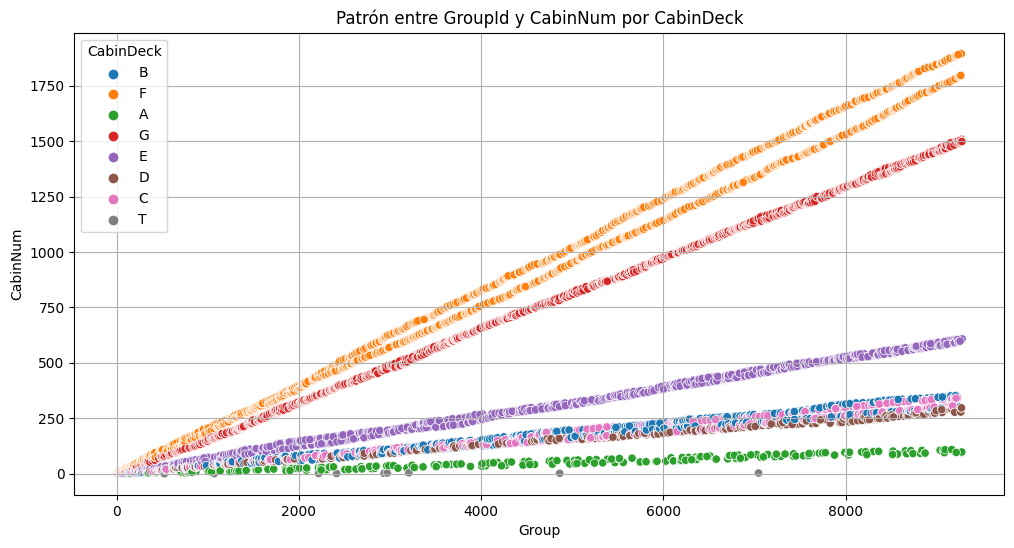

In [175]:
# Estudiamos si hay algún patrón entre el número de grupo y el deck
plt.figure(figsize=(12,6))
sns.scatterplot(data=complete_df, x='GroupId', y='CabinNum', hue='CabinDeck')
plt.title('Patrón entre GroupId y CabinNum por CabinDeck')
plt.xlabel('Group')
plt.ylabel('CabinNum')
plt.legend(title='CabinDeck')
plt.grid(True)
plt.show()

In [176]:
# Hay un claro patrón lineal entre el numero de cabina y el numero del grupo en cada una de las cubierta
# Usaremos esto para rellenar las variables NaN de los numeros de cabinas faltantes
missing = complete_df.loc[complete_df['CabinNum'].isna(), 'CabinDeck'].unique()
known = complete_df.loc[complete_df['CabinNum'].notna(), 'CabinDeck'].unique()

for deck in list(set(missing) & set(known)):
    mask_deck = complete_df['CabinDeck'] == deck
        
    x_train = complete_df.loc[mask_deck & complete_df['CabinNum'].notna(), 'GroupId']
    y_train = complete_df.loc[mask_deck & complete_df['CabinNum'].notna(), 'CabinNum']
    x_test = complete_df.loc[mask_deck & complete_df['CabinNum'].isna(), 'GroupId']

    model = LinearRegression()
    model.fit(x_train.values.reshape(-1, 1), y_train.values)

    preds = model.predict(x_test.values.reshape(-1, 1))
    
    preds = np.round(preds).astype(int)
    preds = np.clip(preds, a_min=0, a_max=2000)

    complete_df.loc[mask_deck & complete_df['CabinNum'].isna(), 'CabinNum'] = preds

In [177]:
print(f'CabinNum Nulls: {complete_df["CabinNum"].isnull().sum()}')

CabinNum Nulls: 0


In [178]:
# Añadimos una variable con sectores de cabinasd
bins = [-1, 300, 600, 900, 1200, 1500, 1800, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7]
complete_df['CabinSector'] = pd.cut(complete_df['CabinNum'], bins=bins, labels=labels)

#### VIP

In [179]:
print(f'VIP Nulls: {complete_df["VIP"].isnull().sum()}')

VIP Nulls: 296


In [180]:
# Revisamos el número total de VIPs
complete_df['VIP'].value_counts().reset_index(name="NumPersonas")

,VIP,NumPersonas
0,False,12401
1,True,273


In [181]:
# Al ser la gran mayoría no VIPS rellenamos los nan con ello
complete_df.loc[complete_df['VIP'].isna(), 'VIP'] = False

In [182]:
print(f'VIP Nulls: {complete_df["VIP"].isnull().sum()}')

VIP Nulls: 0


#### CryoSleep

In [183]:
print(f'CryoSleep Nulls: {complete_df["CryoSleep"].isnull().sum()}')

CryoSleep Nulls: 310


In [184]:
# Revisamos la distribución entre gente con gastos y cryosleep
complete_df['Spent'] = complete_df['TotalExpense'] > 0

complete_df.groupby(['Spent','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
Spent,,
False,740.0,4581.0
True,7339.0,0.0


In [185]:
# Quien esta durmiendo no gasta, pero los que estan despiertos
# mayoritariamente si, por lo que rellenamos los nan con estas reglas
awake_mask = complete_df['CryoSleep'].isna() & (complete_df['TotalExpense'] > 0)
complete_df.loc[awake_mask, 'CryoSleep'] = False

sleep_mask = complete_df['CryoSleep'].isna() & (complete_df['TotalExpense'] == 0)
complete_df.loc[sleep_mask, 'CryoSleep'] = True


In [186]:
print(f'CryoSleep Nulls: {complete_df["CryoSleep"].isnull().sum()}')

CryoSleep Nulls: 0


#### Expenses

In [187]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
dtype: int64 

TotalExpense Nulls: 0


In [188]:
# If you are in CryoSleep you can't have expenses
complete_df.loc[complete_df["CryoSleep"] == True, expenses_cols] = 0
complete_df.loc[complete_df["CryoSleep"] == True, 'TotalExpense'] = 0

# Rellenamos deck con la moda para los solos y no VIP en Europa
soloVIP_mode = europa_solos_noVIP["CabinDeck"].mode().iloc[0]

nan_europa_mask = complete_df["CabinDeck"].isna() & (complete_df["HomePlanet"] == "Europa")
complete_df.loc[nan_europa_mask, 'CabinDeck'] = soloVIP_mode

In [189]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     170
FoodCourt       179
ShoppingMall    172
Spa             173
VRDeck          172
dtype: int64 

TotalExpense Nulls: 0


In [190]:
# Estudiamos la desviación típica interna de los gastos de cada grupo y la comparamos con la global
group_spread = complete_df[complete_df["GroupSize"] > 1].groupby("GroupId")[expenses_cols].std().mean(axis=1).reset_index(name="DispersionMedia")

global_std = complete_df[expenses_cols].std().mean()

print("Desviación media GLOBAL:", global_std)
print("Desviación media INTRA-GRUPO:", group_spread["DispersionMedia"].mean())

# Los gastos dentro del grupo son parecidos comparados con el global

Desviación media GLOBAL: 1022.6062011210357
Desviación media INTRA-GRUPO: 443.53837223580507


In [191]:
# Estudiamos si la distribución es equilibrada para usar media o si no mediana
stats = complete_df[complete_df["GroupSize"] > 1].groupby("GroupId")[expenses_cols].agg(['mean', 'median'])

mean_vals = stats.xs('mean', level=1, axis=1)
median_vals = stats.xs('median', level=1, axis=1)

valid = median_vals > 0
ratio = (mean_vals[valid] / median_vals[valid]).mean(axis=1)

ratio.describe()

# Debido a los outliers mejor usar mediana

count    1358.000000
mean        6.249724
std        25.129010
min         0.683228
25%         1.000000
50%         1.000000
75%         1.000000
max       559.595311
dtype: float64

In [192]:
# Rellenamos todos los gastos con la mediana del grupo
for col in expenses_cols:
    group_median = complete_df[complete_df["GroupSize"] > 1].groupby('GroupId')[col].transform('median')
    
    mask_nan = complete_df[col].isna() & (complete_df["GroupSize"] > 1)
    complete_df.loc[mask_nan, col] = group_median[mask_nan]

In [193]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     117
FoodCourt       113
ShoppingMall     93
Spa             107
VRDeck          102
dtype: int64 

TotalExpense Nulls: 0


In [194]:
# Estudiamos la desviación típica interna de los gastos de cada apellido y la comparamos con la global
surname_spread = complete_df.groupby("Surname")[expenses_cols].std().mean(axis=1).reset_index(name="DispersionMedia")

global_std = complete_df[expenses_cols].std().mean()

print("Desviación media GLOBAL:", global_std)
print("Desviación media INTRA-APELLIDO:", surname_spread["DispersionMedia"].mean())

# Los gastos dentro del grupo son parecidos comparados con el global

Desviación media GLOBAL: 1022.5903696170659
Desviación media INTRA-APELLIDO: 529.019717555048


In [195]:
# Estudiamos si la distribución es equilibrada para usar media o si no mediana
stats = complete_df.groupby("Surname")[expenses_cols].agg(['mean', 'median'])

mean_vals = stats.xs('mean', level=1, axis=1)
median_vals = stats.xs('median', level=1, axis=1)

median_vals_clean = median_vals.replace([np.inf, -np.inf], np.nan)

mean_vals_clean = mean_vals.replace([np.inf, -np.inf], np.nan)
median_vals_clean = median_vals.replace([np.inf, -np.inf], np.nan)

valid = median_vals_clean > 0
ratio = (mean_vals_clean[valid] / median_vals_clean[valid]).mean(axis=1)

ratio.describe()

# Debido a los outliers mejor usar mediana

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


count    1518.000000
mean       40.365112
std       119.391044
min         0.628205
25%         1.000000
50%         5.598267
75%        30.866328
max      1686.500000
dtype: float64

In [196]:
# Rellenamos todos los gastos con la mediana del surname
for col in expenses_cols:
    surname_median = complete_df.groupby('Surname')[col].transform('median')
    
    mask_nan = complete_df[col].isna() & (complete_df["GroupSize"] == 1)
    complete_df.loc[mask_nan, col] = surname_median[mask_nan]

In [197]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     2
FoodCourt       5
ShoppingMall    3
Spa             2
VRDeck          3
dtype: int64 

TotalExpense Nulls: 0


In [198]:
# Los nan restantes los rellenamos según la mediana de su HomePlanet para solo travellers
for col in expenses_cols:
    # Mediana por planeta
    planet_median = complete_df[complete_df["GroupSize"] == 1].groupby("HomePlanet")[col].transform("median")
    
    # Solo rellenamos NaN reales
    mask = complete_df[col].isna() & (complete_df["GroupSize"] == 1)
    complete_df.loc[mask, col] = planet_median[mask]

In [199]:
print(f'Expenses Nulls: \n{complete_df[expenses_cols].isnull().sum()} \n\nTotalExpense Nulls: {complete_df["TotalExpense"].isnull().sum()}')

Expenses Nulls: 
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64 

TotalExpense Nulls: 0


In [200]:
# Actualizamos TotalExpense y Spent
complete_df['TotalExpense'] = complete_df[expenses_cols].sum(axis=1)

complete_df['Spent'] = complete_df['TotalExpense'] > 0

#### Age

In [201]:
print(f'Age Nulls: {complete_df["Age"].isnull().sum()}')

Age Nulls: 270


In [202]:
# Estudiamos cual es la combinación de variables que minimizan la desviación típica de la edad
subgroup_cols = ['GroupSize', 'HomePlanet', 'Destination', 'Spent', 'CryoSleep', 'VIP']

age_spread = complete_df.groupby(subgroup_cols)['Age'].std().reset_index(name="DispersionMedia")
global_std = complete_df['Age'].std()

print("Desviación media GLOBAL:", global_std)
print("Desviación media INTRA-APELLIDO:", age_spread["DispersionMedia"].mean())

# La edad en estos subgrupos es más parecida que la media global

Desviación media GLOBAL: 14.387260917143237
Desviación media INTRA-APELLIDO: 10.868963310000707


In [203]:
# Rellenamos la edad con la mediana del subgrupo
age_median_subgroup = complete_df.groupby(subgroup_cols)['Age'].transform('median')

age_nan_mask = complete_df['Age'].isna()
complete_df.loc[age_nan_mask, 'Age'] = age_median_subgroup[age_nan_mask]

In [204]:
print(f'Age Nulls: {complete_df["Age"].isnull().sum()}')

Age Nulls: 0


In [205]:
# Añadimos una variable con categorias de edad
bins = [0, 12, 18, 30, 50, 80]
labels = ['Child','Teen','Young','Adult','Elder']
complete_df['AgeCategory'] = pd.cut(complete_df['Age'], bins=bins, labels=labels)

In [206]:
# Eliminamos las variables irrelevantes para los modelos
complete_df = complete_df.drop(columns=['Cabin', 'Name','Surname'])

In [207]:
print(f'Total Nulls: \n\n{complete_df.isnull().sum()}')

Total Nulls: 

PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
GroupId           0
GroupSize         0
Solo              0
CabinDeck         0
CabinNum          0
CabinSide         0
TotalExpense      0
CabinSector       0
Spent             0
AgeCategory     260
dtype: int64


In [208]:
complete_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupSize,CabinNum,TotalExpense
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.00000,12970.000000
mean,28.709483,219.667849,445.134194,171.846839,303.374595,303.223207,4635.337471,2.022976,603.21835,1443.246685
std,14.285075,642.540116,1572.792261,585.480777,1119.296198,1175.209268,2685.904299,1.577102,512.67006,2820.751173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2306.250000,1.000000,170.00000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4632.000000,1.000000,431.00000,717.000000
75%,37.000000,46.000000,69.000000,25.000000,53.000000,39.000000,6924.750000,2.000000,1008.00000,1445.750000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000,8.000000,1894.00000,35987.000000


### Data Visualization

In [209]:
train_df = complete_df[complete_df['PassengerId'].isin(train_df['PassengerId'].values)].copy()
train_df = train_df.merge(target_df, on='PassengerId', how='left')

test_df = complete_df[complete_df['PassengerId'].isin(test_df['PassengerId'].values)].copy()

#### Global Rate of Transported Passengers

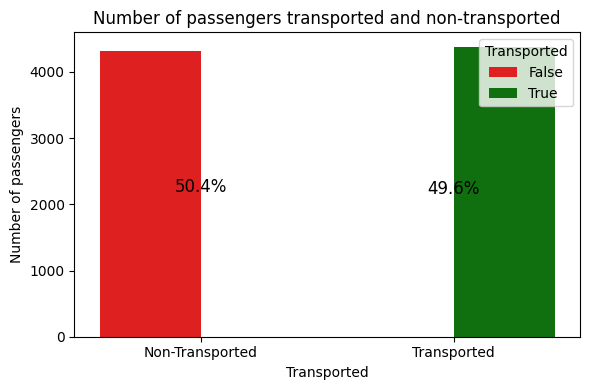

In [210]:
survival_counts = train_df['Transported'].value_counts()
survival_proportion = train_df['Transported'].value_counts(normalize=True)

plt.figure(figsize=(6,4))
sns.barplot(x=survival_counts.index, y=survival_counts.values, hue=survival_counts.index, palette=['red','green'])
plt.title('Number of passengers transported and non-transported')
plt.ylabel('Number of passengers')
plt.xticks([0,1], ['Non-Transported', 'Transported'])

for i, value in enumerate(survival_counts.values):
    percentage = survival_proportion.iloc[i] * 100
    plt.text(i, value/2, f"{percentage:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

#### Transported Rate by Age

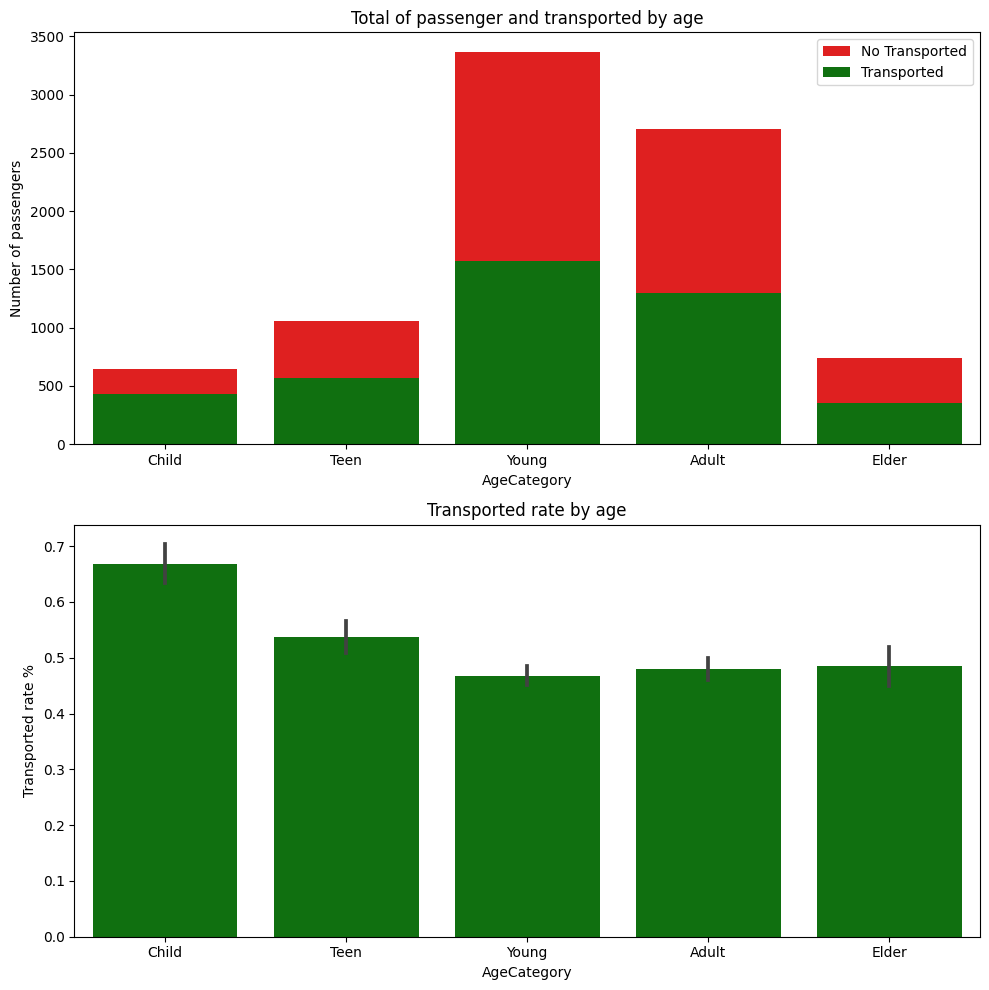

In [211]:
age_stats = train_df.groupby('AgeCategory', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=age_stats.index, y=age_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=age_stats.index, y=age_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by age')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='AgeCategory', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by age')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by Solo

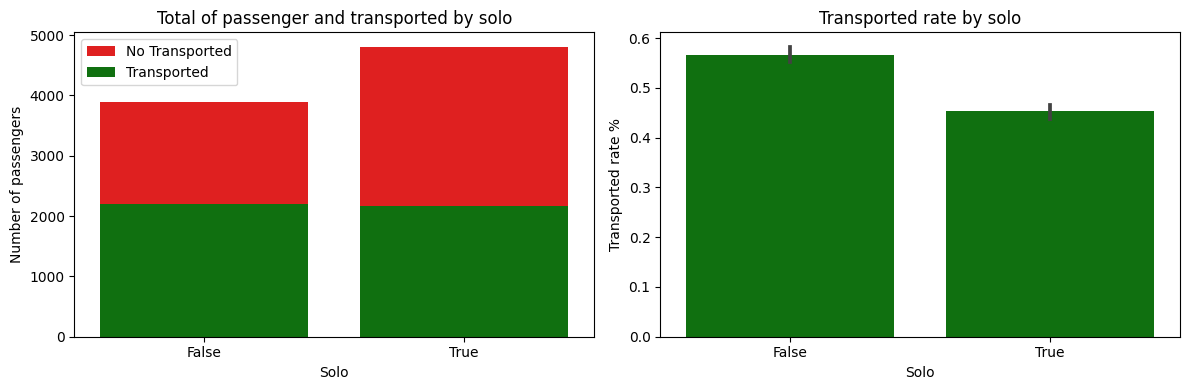

In [212]:
solo_stats = train_df.groupby('Solo', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=solo_stats.index, y=solo_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=solo_stats.index, y=solo_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by solo')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Solo', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by solo')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by GroupSize

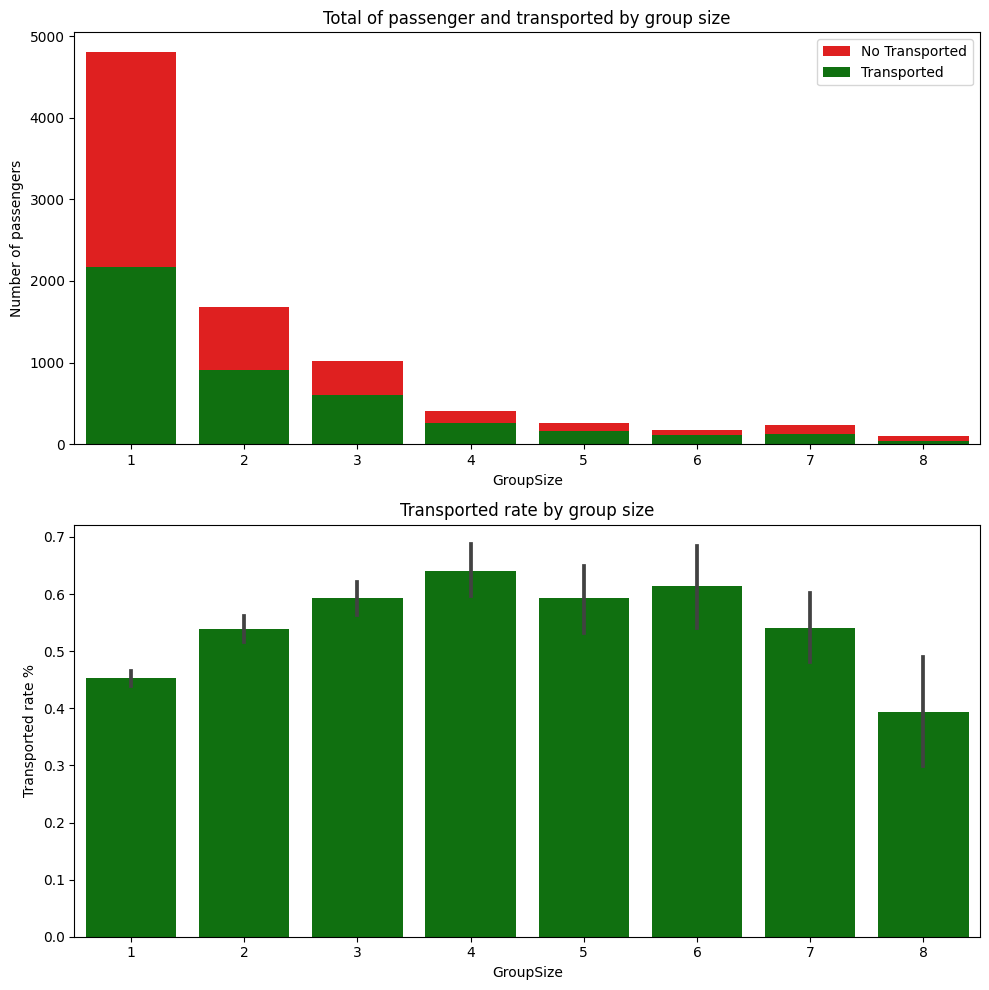

In [213]:
group_stats = train_df.groupby('GroupSize', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=group_stats.index, y=group_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=group_stats.index, y=group_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by group size')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='GroupSize', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by group size')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by CryoSleep

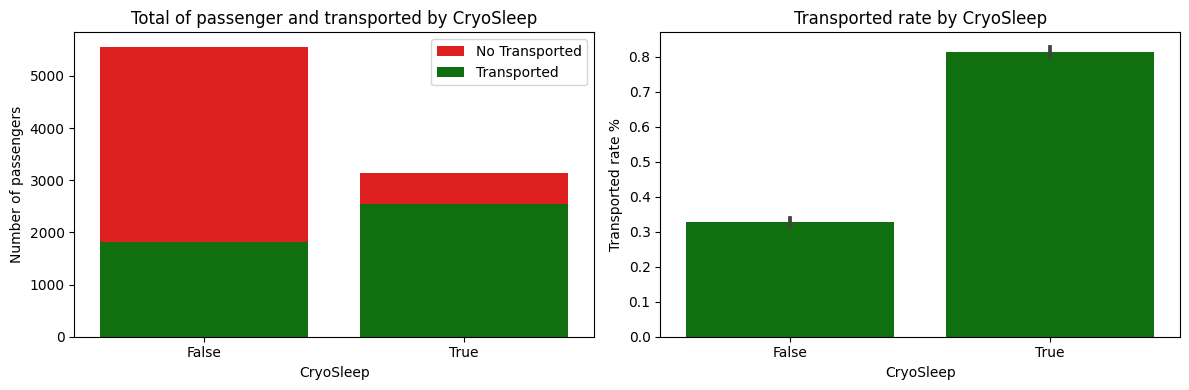

In [214]:
cryosleep_stats = train_df.groupby('CryoSleep', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=cryosleep_stats.index, y=cryosleep_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=cryosleep_stats.index, y=cryosleep_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by CryoSleep')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='CryoSleep', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by CryoSleep')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by VIP

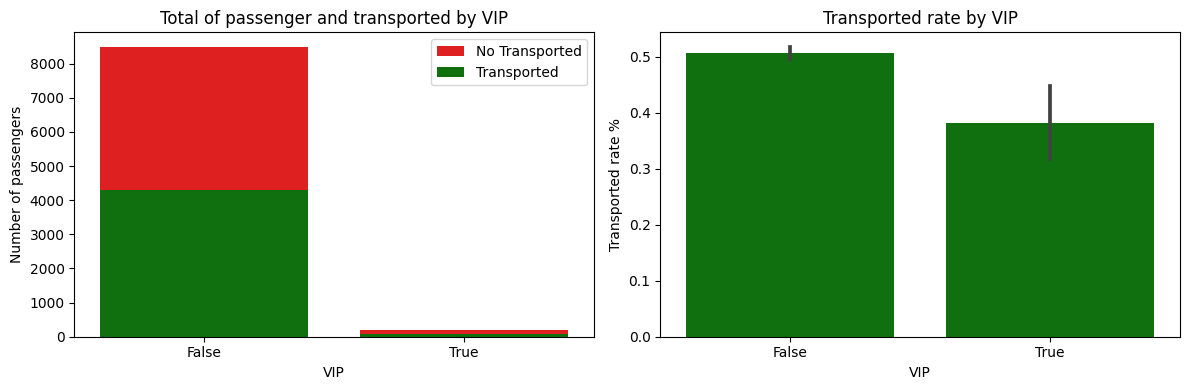

In [215]:
vip_stats = train_df.groupby('VIP', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=vip_stats.index, y=vip_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=vip_stats.index, y=vip_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by VIP')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='VIP', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by VIP')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by HomePlanet

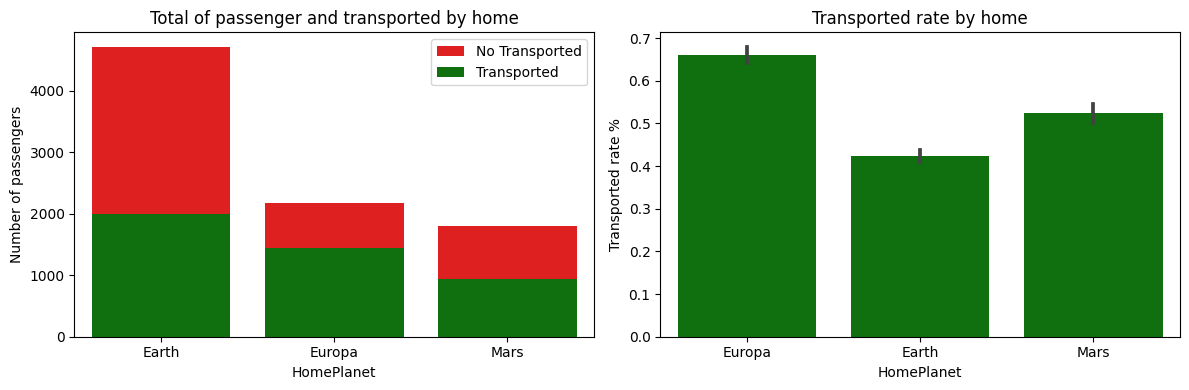

In [216]:
home_stats = train_df.groupby('HomePlanet', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=home_stats.index, y=home_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=home_stats.index, y=home_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by home')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='HomePlanet', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by home')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by Destination

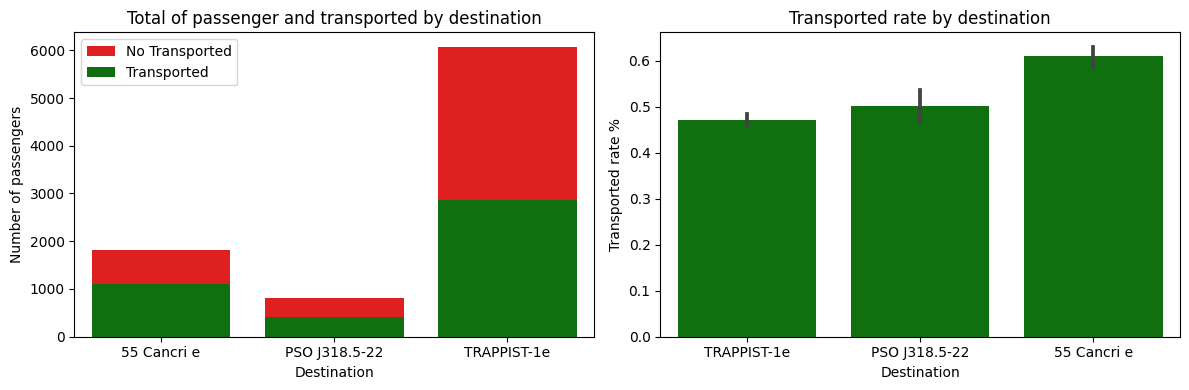

In [217]:
destination_stats = train_df.groupby('Destination', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=destination_stats.index, y=destination_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=destination_stats.index, y=destination_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by destination')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Destination', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by destination')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by CabinSide

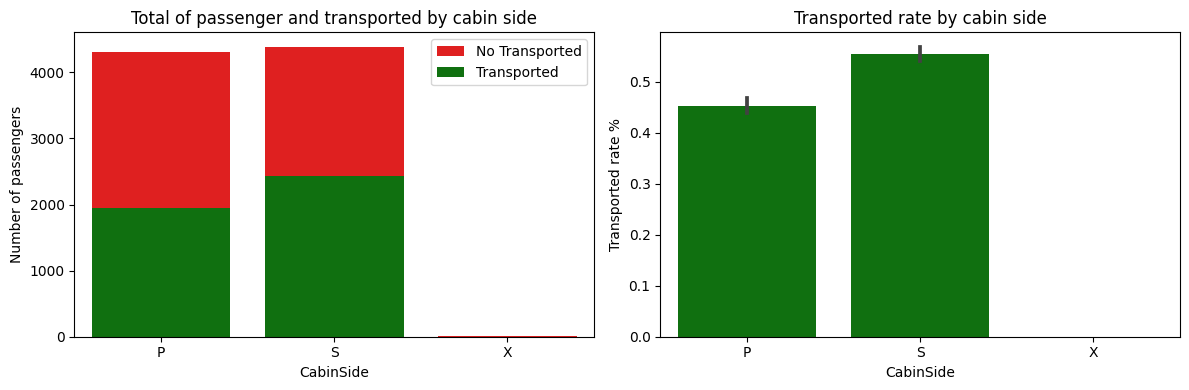

In [218]:
cabin_stats = train_df.groupby('CabinSide', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=cabin_stats.index, y=cabin_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=cabin_stats.index, y=cabin_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by cabin side')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='CabinSide', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by cabin side')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by CabinDeck

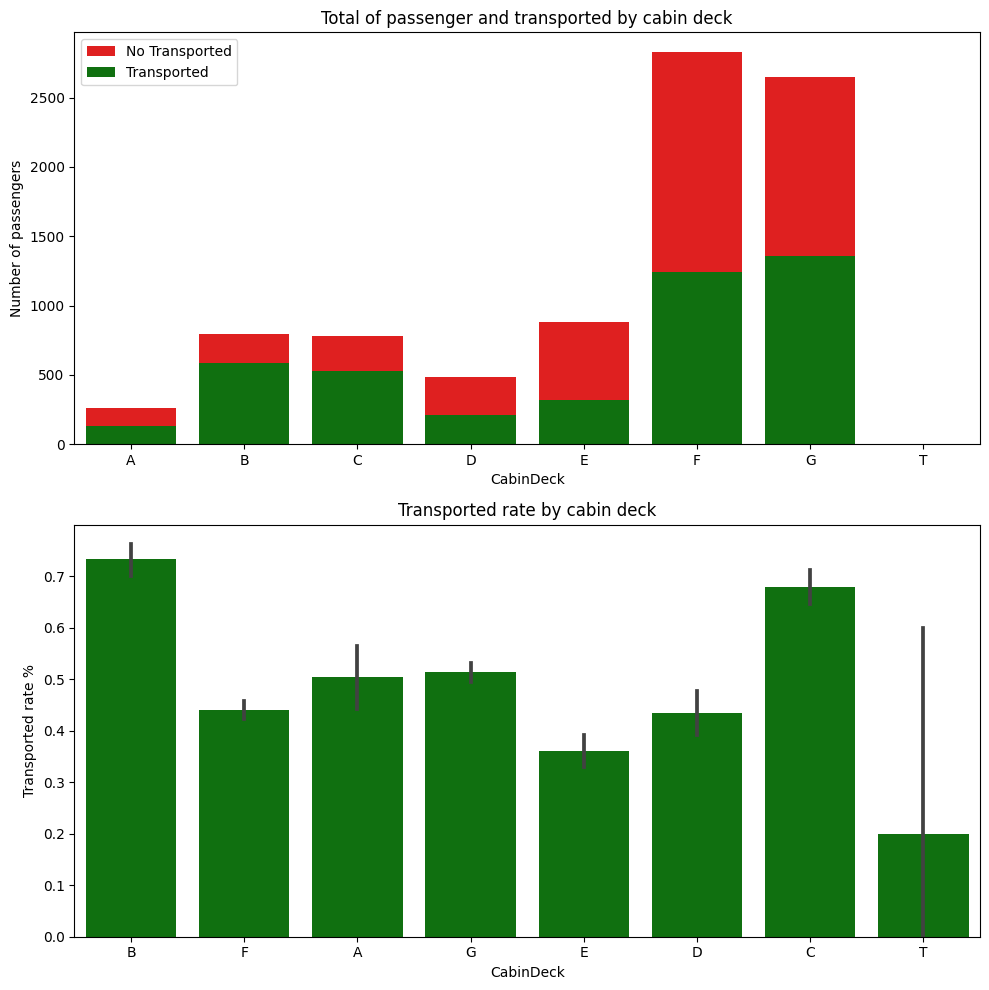

In [219]:
cabin_stats = train_df.groupby('CabinDeck', observed=True)['Transported'].agg(total='count', transported='sum')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=cabin_stats.index, y=cabin_stats['total'], color='red', label="No Transported", ax=axes[0])
sns.barplot(x=cabin_stats.index, y=cabin_stats['transported'], color='green', label="Transported", ax=axes[0])
axes[0].set_title('Total of passenger and transported by cabin deck')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='CabinDeck', y='Transported', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Transported rate by cabin deck')
axes[1].set_ylabel('Transported rate %')

plt.tight_layout()
plt.show()

#### Transported Rate by CabinDeck and CabinSide

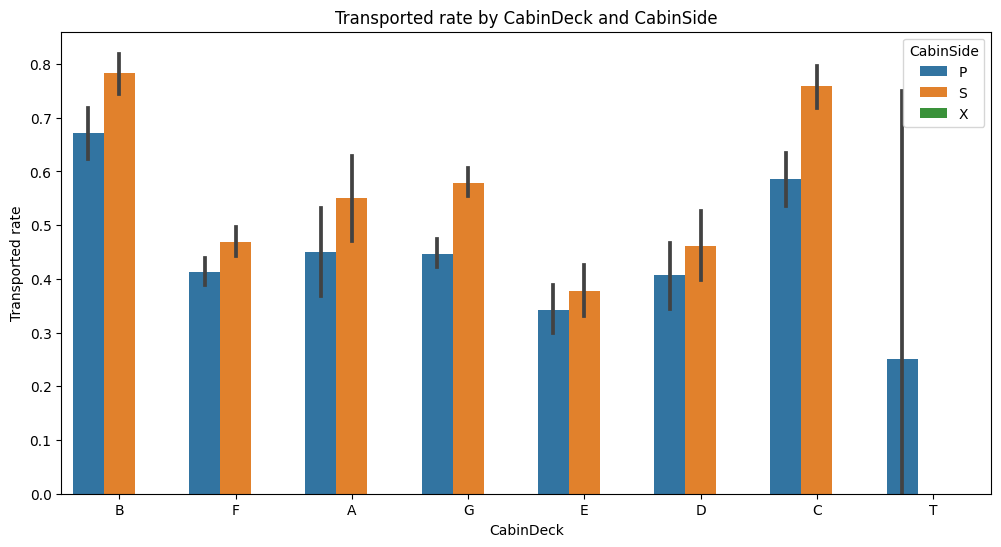

In [220]:
plt.figure(figsize=(12,6))
sns.barplot(x='CabinDeck', y='Transported', hue='CabinSide', data=train_df)
plt.title('Transported rate by CabinDeck and CabinSide')
plt.ylabel('Transported rate')
plt.show()

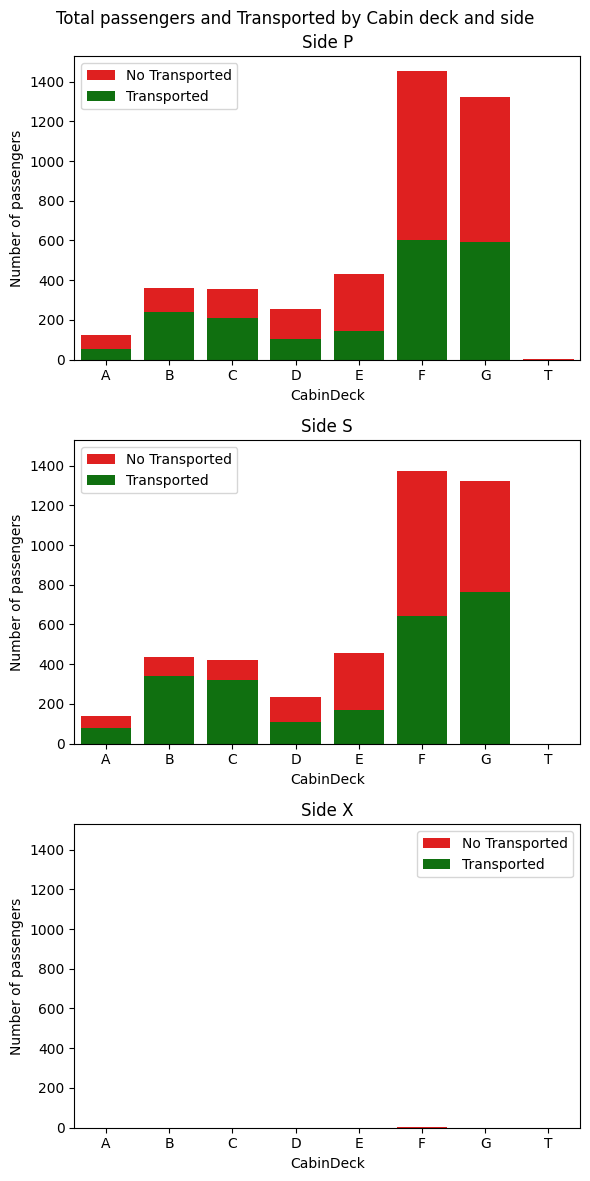

In [221]:
deck_side_stats = train_df.groupby(['CabinSide','CabinDeck'], observed=True)['Transported'].agg(total='count', transported='sum').unstack()
fig, axes = plt.subplots(3, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(deck_side_stats.index):
    ax = axes[i]
    transported = deck_side_stats.loc[cls]['transported']
    total = deck_side_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Transported", ax=ax)
    sns.barplot(x=total.index, y=transported, color='green', label="Transported", ax=ax)
    ax.set_title(f'Side {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and Transported by Cabin deck and side')

plt.tight_layout()
plt.show()

#### Transported Rate by Age and CryoSleep

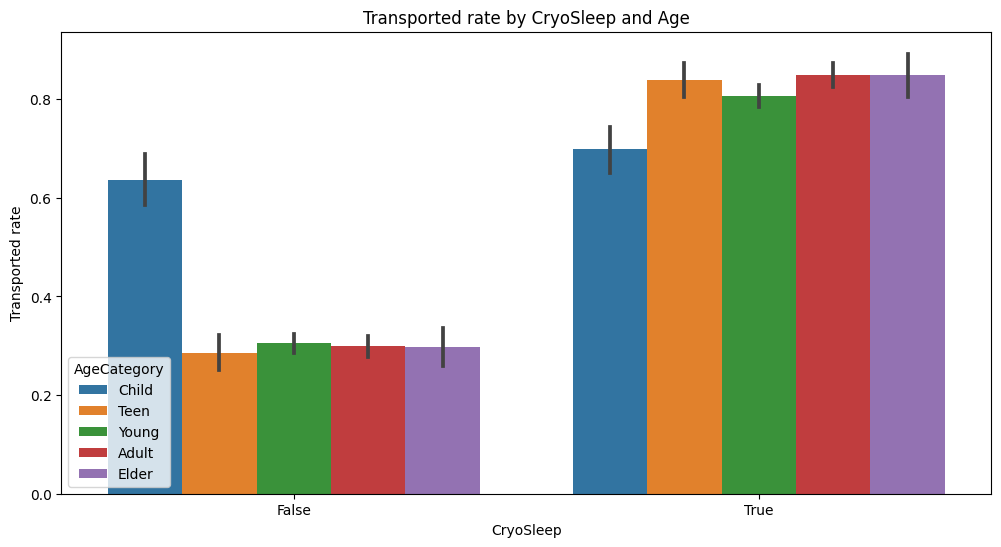

In [222]:
plt.figure(figsize=(12,6))
sns.barplot(x='CryoSleep', y='Transported', hue='AgeCategory', data=train_df)
plt.title('Transported rate by CryoSleep and Age')
plt.ylabel('Transported rate')
plt.show()

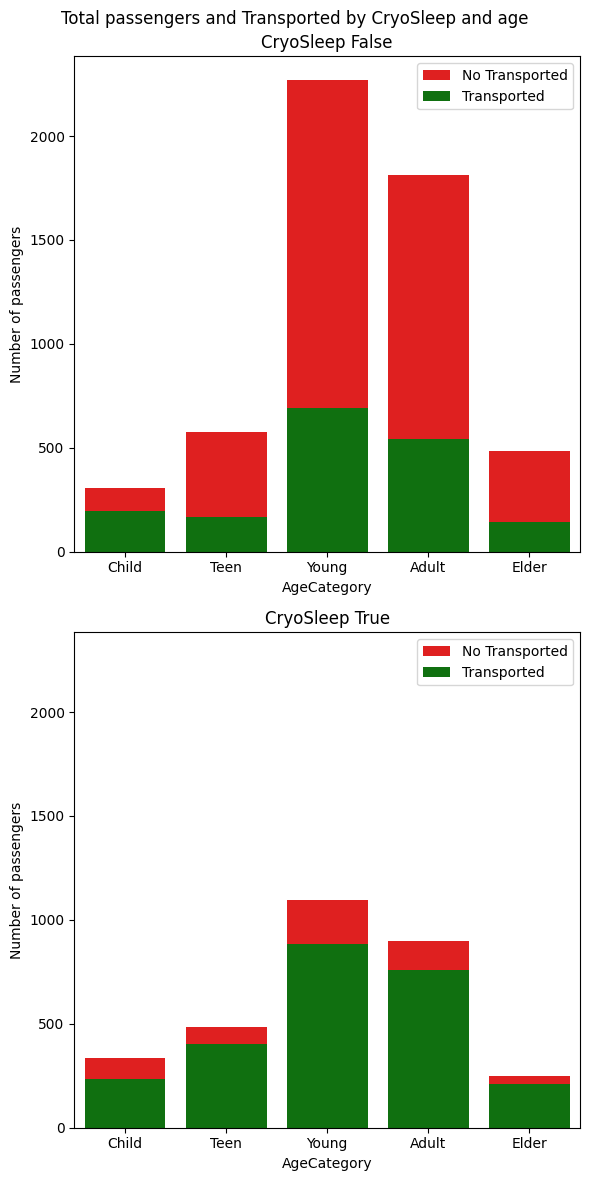

In [223]:
cryo_age_stats = train_df.groupby(['CryoSleep','AgeCategory'], observed=True)['Transported'].agg(total='count', transported='sum').unstack()
fig, axes = plt.subplots(2, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(cryo_age_stats.index):
    ax = axes[i]
    transported = cryo_age_stats.loc[cls]['transported']
    total = cryo_age_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Transported", ax=ax)
    sns.barplot(x=total.index, y=transported, color='green', label="Transported", ax=ax)
    ax.set_title(f'CryoSleep {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and Transported by CryoSleep and age')

plt.tight_layout()
plt.show()

#### Transported Rate by Age and Solo

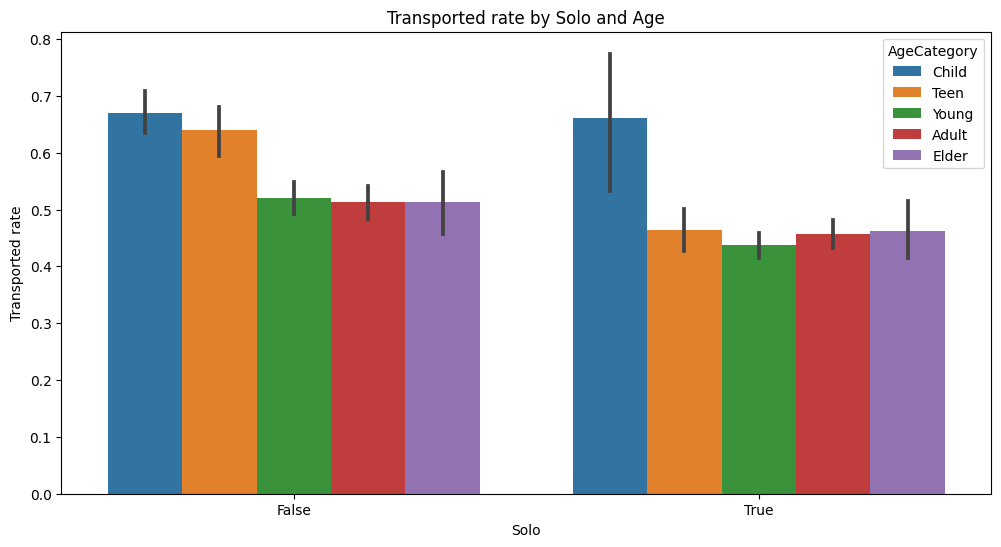

In [224]:
plt.figure(figsize=(12,6))
sns.barplot(x='Solo', y='Transported', hue='AgeCategory', data=train_df)
plt.title('Transported rate by Solo and Age')
plt.ylabel('Transported rate')
plt.show()

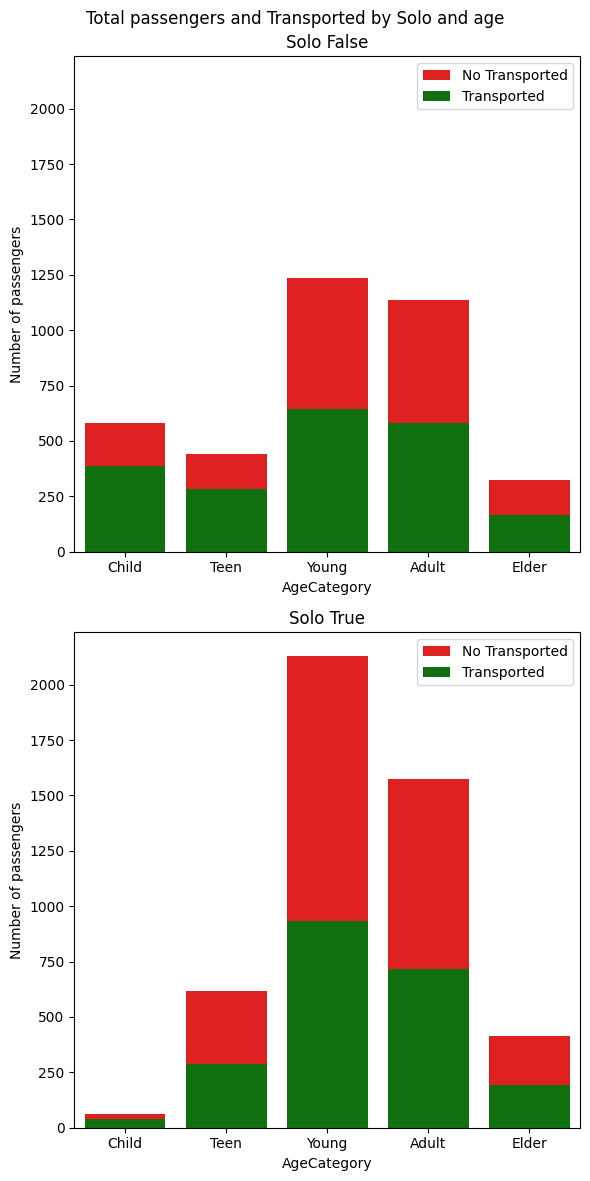

In [225]:
solo_age_stats = train_df.groupby(['Solo','AgeCategory'], observed=True)['Transported'].agg(total='count', transported='sum').unstack()
fig, axes = plt.subplots(2, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(solo_age_stats.index):
    ax = axes[i]
    transported = solo_age_stats.loc[cls]['transported']
    total = solo_age_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Transported", ax=ax)
    sns.barplot(x=total.index, y=transported, color='green', label="Transported", ax=ax)
    ax.set_title(f'Solo {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and Transported by Solo and age')

plt.tight_layout()
plt.show()

#### Transported Rate by Home and Destination

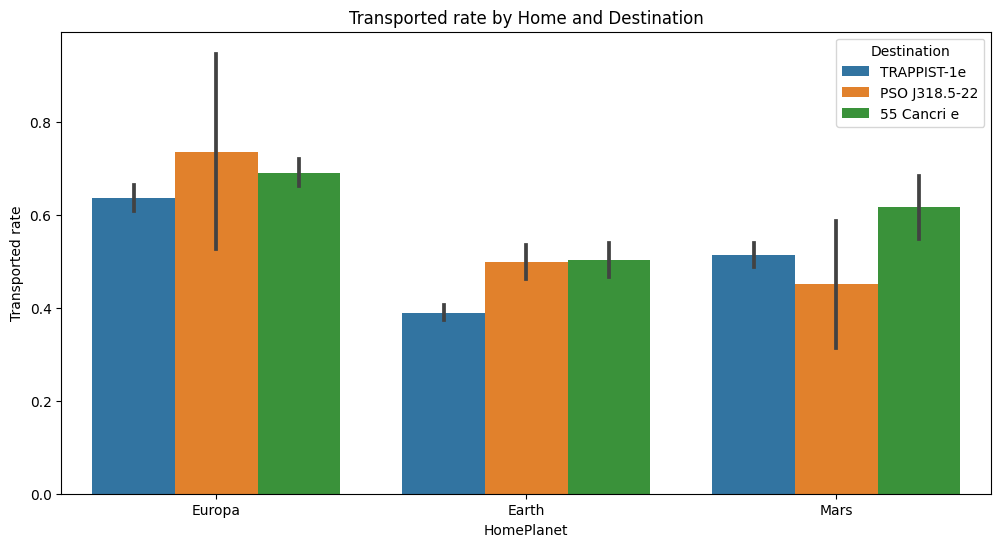

In [226]:
plt.figure(figsize=(12,6))
sns.barplot(x='HomePlanet', y='Transported', hue='Destination', data=train_df)
plt.title('Transported rate by Home and Destination')
plt.ylabel('Transported rate')
plt.show()

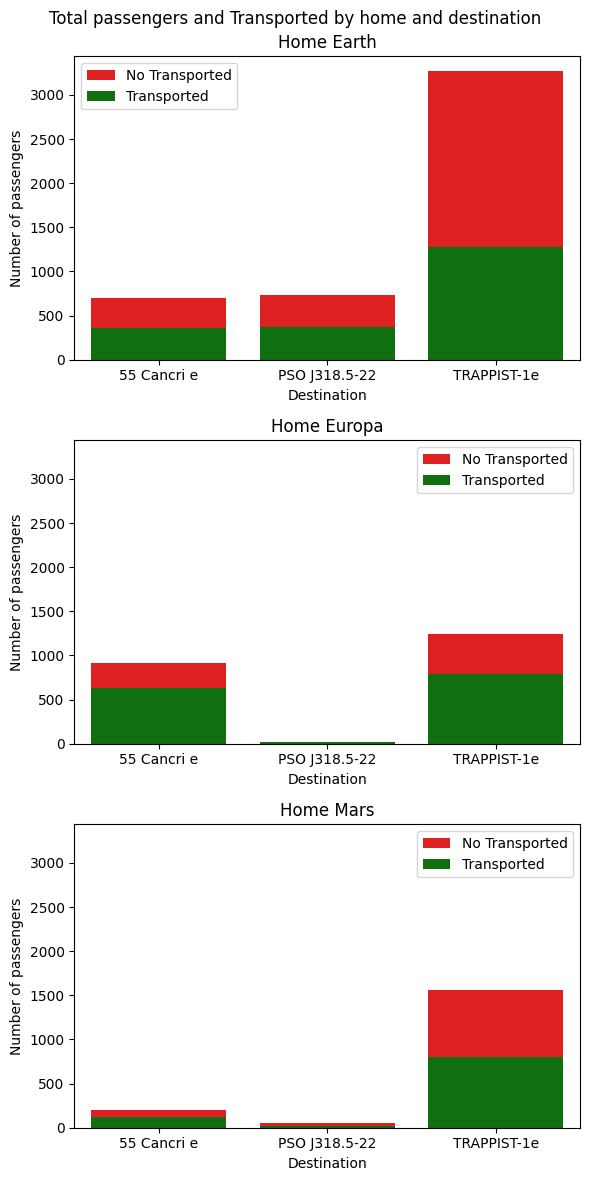

In [227]:
home_dest_stats = train_df.groupby(['HomePlanet','Destination'], observed=True)['Transported'].agg(total='count', transported='sum').unstack()
fig, axes = plt.subplots(3, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(home_dest_stats.index):
    ax = axes[i]
    transported = home_dest_stats.loc[cls]['transported']
    total = home_dest_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Transported", ax=ax)
    sns.barplot(x=total.index, y=transported, color='green', label="Transported", ax=ax)
    ax.set_title(f'Home {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and Transported by home and destination')

plt.tight_layout()
plt.show()

## Model Development and Training

In [228]:
# Making a clean df for the training with less features
train_clean_df = train_df.copy()
test_clean_df = test_df.copy()

delete_columns = ['PassengerId', 'Spent']

train_clean_df = train_clean_df.drop(columns = delete_columns)
test_clean_df = test_clean_df.drop(columns = delete_columns)

In [229]:
# Building and training the predictor with autogluon
predictor = TabularPredictor(label='Transported', eval_metric='accuracy')
predictor.fit(train_data=train_clean_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20251112_191711"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.54 GB / 31.35 GB (94.2%)
Disk Space Avail:   19.20 GB / 19.52 GB (98.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU mem

In [230]:
# Best trained models
predictor.leaderboard(train_clean_df)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestGini,0.978373,0.787356,accuracy,0.193276,0.102137,1.853483,0.193276,0.102137,1.853483,1,True,3
1,RandomForestEntr,0.977683,0.780460,accuracy,0.226843,0.089344,2.165796,0.226843,0.089344,2.165796,1,True,4
2,ExtraTreesGini,0.977108,0.774713,accuracy,0.277624,0.100449,1.205021,0.277624,0.100449,1.205021,1,True,6
3,ExtraTreesEntr,0.976763,0.771264,accuracy,0.319732,0.099390,1.205627,0.319732,0.099390,1.205627,1,True,7
4,LightGBMLarge,0.901185,0.798851,accuracy,0.043218,0.007122,2.080337,0.043218,0.007122,2.080337,1,True,10
5,LightGBM,0.887841,0.808046,accuracy,0.084106,0.011459,1.046015,0.084106,0.011459,1.046015,1,True,2
6,XGBoost,0.882204,0.802299,accuracy,0.086085,0.012646,1.321552,0.086085,0.012646,1.321552,1,True,9
7,LightGBMXT,0.848959,0.808046,accuracy,0.088626,0.016278,1.080511,0.088626,0.016278,1.080511,1,True,1
8,CatBoost,0.836420,0.820690,accuracy,0.020897,0.006371,7.113719,0.020897,0.006371,7.113719,1,True,5
9,WeightedEnsemble_L2,0.836420,0.820690,accuracy,0.023252,0.007216,7.188445,0.002355,0.000845,0.074726,2,True,11


In [231]:
# Making predictions and saving to CSV
predictions = predictor.predict(test_clean_df)

submission_stack = pd.DataFrame({
    'PassengerId': test_df["PassengerId"],
    'Transported': predictions})

submission_stack.to_csv('submission_auto.csv', index=False)

## Conclusions and Insights